# Solar Radiation

Solar radiation is the lifeblood of agriculture, driving the fundamental processes of photosynthesis and plant growth. Measuring solar irradiance is therefore essential for estiamting yield potential and modeling agricultural crops. The incident solar radiation on given location is highly influenced by the latitudinal position. In this exercise we examine a method to derive the estimated maximum solar irradiance for each day of the year from a time series of solar radiation observations. Before we start, there are a few terms that need to be defined:

- **Extraterrestrial solar irradiance**: This is the solar radiation received outside the Earth's atmosphere on a surface perpendicular to the sun's rays. It represents the maximum potential solar energy that could be received by the planet without atmospheric interference.

- **Clear sky solar irradiance**: This refers to the amount of solar radiation that reaches the Earth's surface when the sky is clear, without clouds. It is the solar irradiance under ideal clear conditions, accounting for the scattering and absorption by the atmospheric components but excluding the impact of clouds.

- **Solar irradiance observed at the land surface**: This is the actual solar radiation that reaches the ground, taking into account cloud cover, air pollution, and the angle of the sun. This measurement reflects the true solar energy available for crops at specific locations and times.


In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [7]:
# Load dataset
df = pd.read_csv("../datasets/KS_Manhattan_6_SSW.csv", na_values=[-9999])
df.head()


,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,53974,20031001,1.201,-96.61,39.1,NaN,NaN,NaN,NaN,NaN,...,-99.0,-99.0,-99.0,-99,-99,NaN,NaN,NaN,NaN,NaN
1,53974,20031002,1.201,-96.61,39.1,18.9,2.5,10.7,11.7,0.0,...,-99.0,-99.0,-99.0,-99,-99,NaN,NaN,NaN,NaN,NaN
2,53974,20031003,1.201,-96.61,39.1,22.6,8.1,15.4,14.8,0.0,...,-99.0,-99.0,-99.0,-99,-99,NaN,NaN,NaN,NaN,NaN
3,53974,20031004,1.201,-96.61,39.1,22.6,3.8,13.2,14.0,0.0,...,-99.0,-99.0,-99.0,-99,-99,NaN,NaN,NaN,NaN,NaN
4,53974,20031005,1.201,-96.61,39.1,25.0,10.6,17.8,17.3,0.0,...,-99.0,-99.0,-99.0,-99,-99,NaN,NaN,NaN,NaN,NaN


In [8]:
# Convert date string to pandas datetime format
df["LST_DATE"] = pd.to_datetime(df["LST_DATE"], format="%Y%m%d")
df["LST_DATE"].head() # Check our conversion.


0   2003-10-01
1   2003-10-02
2   2003-10-03
3   2003-10-04
4   2003-10-05
Name: LST_DATE, dtype: datetime64[ns]

In [9]:
# Add year, month, and day of the year to summarize data in future steps.
df["YEAR"] = df["LST_DATE"].dt.year
df["MONTH"] = df["LST_DATE"].dt.month
df["DOY"] = df["LST_DATE"].dt.dayofyear


## Inspect timeseries

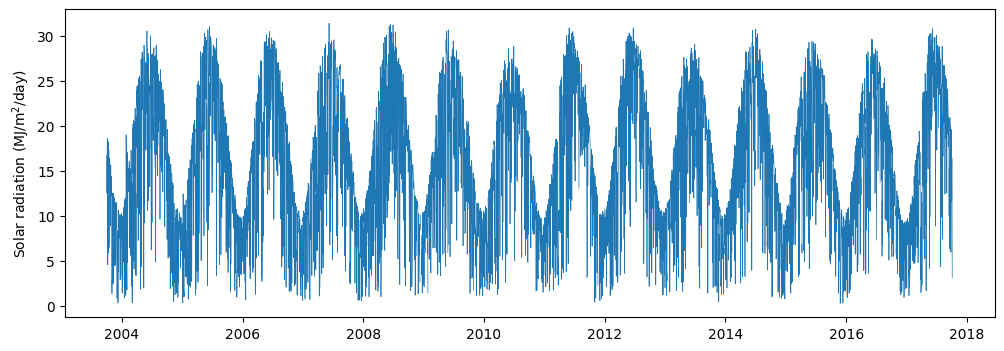

In [11]:
# Observe trends in solar radiation data
plt.figure(figsize=(12,4))
plt.plot(df["LST_DATE"], df["SOLARAD_DAILY"], linewidth=0.5)
plt.ylabel("Solar radiation (MJ/m$^2$/day)" )
plt.show()


## Clear sky solar irradiance: empirical method

To approximate the clear sky solar irradiance we will select the highest records from our observations. To do this we will use a moving/rolling percentile filter. Alternatively, we can use the `.max()` function instead of the `.quantile(0.99)` function.


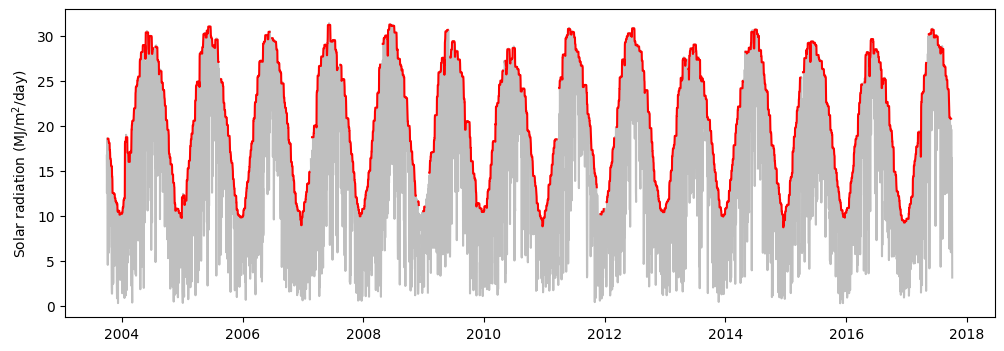

In [16]:
# clear sky solar radiation from observations
df["Rso_obs"] = df["SOLARAD_DAILY"].rolling(window=15, center=True).quantile(0.99)

# Observe trends in solar radiation data
plt.figure(figsize=(12,4))
plt.plot(df["LST_DATE"], df["SOLARAD_DAILY"], '-k', alpha=0.25)
plt.plot(df["LST_DATE"], df["Rso_obs"], '-r')
plt.ylabel("Solar radiation (MJ/m$^2$/day)" )
plt.show()


## Clear sky solar irradiance: latitude and elevation method

Another alternative is to compute the clear sky solar irradiance based on the latitude and elevation of the location of interest. The first step consists of computing the extraterrestrial radiation for daily periods as defined in Eq. 21 of the FAO-56 manual, and in a subsequent step we compute the clear sky solar radiation.

$$Ra = 24(60)/\pi \hspace{2mm}Gsc \hspace{2mm} dr(\omega\sin(\phi)\sin(\delta)+\cos(\phi)\cos(\delta)\sin(\omega))$$

$Ra$ = extraterrestrial radiation (MJ / m2 /day)

$Gsc$ = 0.0820 solar constant (MJ/m2/min)

$dr = 1 + 0.033\cos(\frac{2\pi J}{365})$ is the inverse relative distance Earth-Sun                            

$J$ = day of the year     

$\phi$ = $\pi/180 Lat$ latitude in radians

$\delta = 0.409\sin((2\pi J/365)-1.39)\hspace{5mm}$ is the solar decimation (rad)

$\omega = \pi/2-(\arccos(-\tan(\phi)\tan(\delta)) \hspace{5mm}$ is the sunset hour angle (radians) 


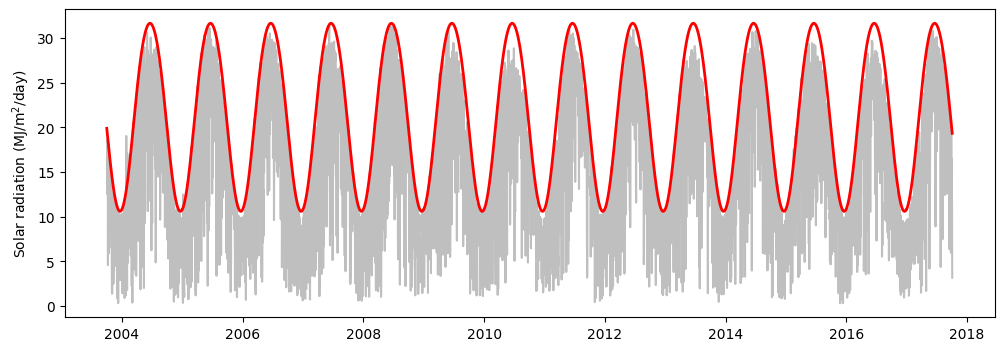

In [19]:
latitude = 39.1949 # Latitude in decimal degrees (North)
elevation = 300 # elevation in meters above sea level
J = df["DOY"] # Use J to match manual notation

# Step 1: Extraterrestrial solar radiation
phi = np.pi/180 * latitude # Eq. 22, FAO-56   
dr = 1 + 0.033 * np.cos(2*np.pi*J/365)  # Eq. 23, FAO-56 
d = 0.409*np.sin((2*np.pi * J/365) - 1.39)
omega = (np.arccos(-np.tan(phi)*np.tan(d)))
Gsc = 0.0820
Ra = 24*(60)/np.pi * Gsc * dr * (omega*np.sin(phi)*np.sin(d) + np.cos(phi)*np.cos(d)*np.sin(omega))

# Step 2: Clear Sky Radiation: Rso (MJ/m2/day)                                        
df["Rso_lat"] =  (0.75 + (2*10**-5)*elevation)*Ra  # Eq. 37, FAO-56


# Plot clear sky using latitude and elevation
plt.figure(figsize=(12,4))
plt.plot(df["LST_DATE"], df["SOLARAD_DAILY"], '-k', alpha=0.25)
plt.plot(df["LST_DATE"], df["Rso_lat"], '-r', linewidth=2)
plt.ylabel("Solar radiation (MJ/m$^2$/day)" )
plt.show()

## Actual solar irradiance from air temperature


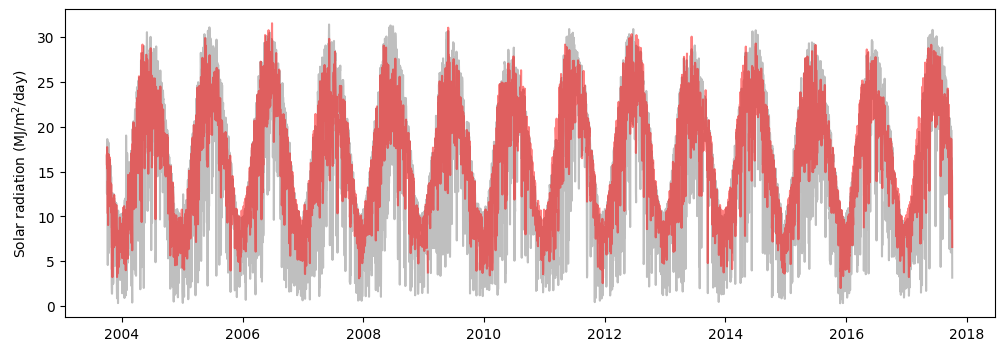

In [21]:
# Clear sky from air temperature observations
df["Rso_temp"] = np.minimum(0.16*Ra*(df["T_DAILY_MAX"]-df["T_DAILY_MIN"])**0.5, df['Rso_lat']) # Eq. 50, FAO-56

plt.figure(figsize=(12,4))
plt.plot(df["LST_DATE"], df["SOLARAD_DAILY"], '-k', alpha=0.25)
plt.plot(df["LST_DATE"], df["Rso_temp"], '-r', alpha=0.5)
plt.ylabel("Solar radiation (MJ/m$^2$/day)" )
plt.show()


## Clear sky solar radiation for each DOY

In [22]:
# Summarize previous variables for each DOY
Rso_doy = df.groupby("DOY")[["SOLARAD_DAILY","Rso_temp","Rso_obs","Rso_lat"]].mean()
Rso_doy.head()


,SOLARAD_DAILY,Rso_temp,Rso_obs,Rso_lat
DOY,,,,
1,7.840714,7.915730,10.522923,10.834404
2,7.135000,8.016919,10.558046,10.876334
3,6.400769,8.236705,10.634077,10.921631
4,6.673077,6.975503,10.738108,10.970287
5,7.897692,7.595476,10.751031,11.022290


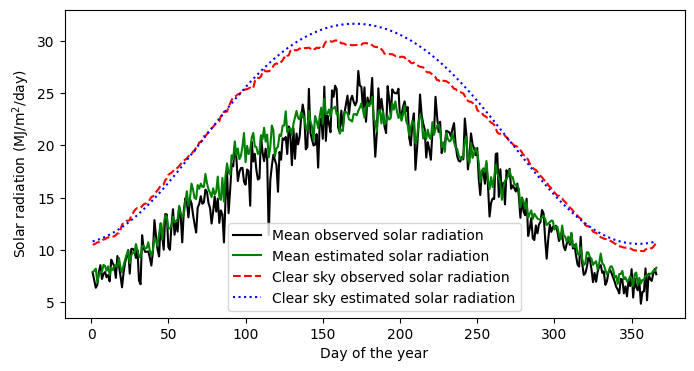

In [24]:
# Create figure comparing the three methods with the observed solar radaition data
plt.figure(figsize=(8,4))
plt.plot(Rso_doy.index, Rso_doy["SOLARAD_DAILY"], '-k',label="Mean observed solar radiation")
plt.plot(Rso_doy.index, Rso_doy["Rso_temp"], '-g', label="Mean estimated solar radiation")

plt.plot(Rso_doy.index, Rso_doy["Rso_obs"], '--r', label="Clear sky observed solar radiation")
plt.plot(Rso_doy.index, Rso_doy["Rso_lat"], ':b', label="Clear sky estimated solar radiation")

plt.xlabel("Day of the year")
plt.ylabel("Solar radiation (MJ/m$^2$/day)")
plt.legend()
plt.show()